In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, classification_report

In [2]:
data = pd.read_csv(r"C:\Users\amit9\Downloads\Fraud.csv")

In [3]:
data.shape

(6362620, 11)

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Cleaning

In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#### No Null values present

In [6]:
data.duplicated().sum()

0

#### No Duplicate entries in the data

In [7]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# EDA

In [8]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [9]:
data.describe(include = 'O')

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [11]:
data['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [12]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

<Axes: >

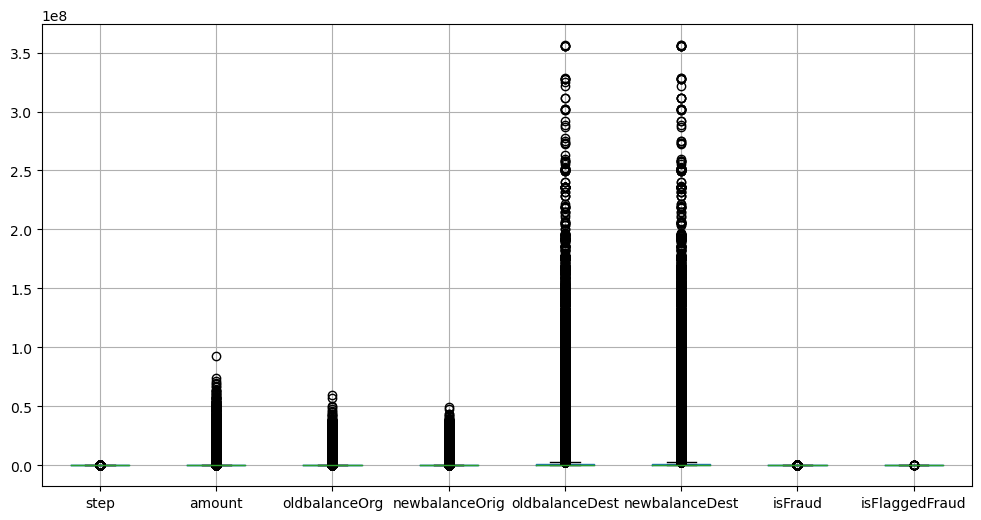

In [13]:
data.boxplot(figsize = (12,6))

In [14]:
#selecting the numeric columns
numeric_columns = data.select_dtypes(include = ['int64', 'float64'])

def outlier_detection(column):
    # calculating the quantiles for each column
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # calculating lower bound and upper bound
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(data)) * 100
        return column, percentage

In [15]:
columns_with_outliers = [outlier_detection(column) for column in numeric_columns.columns]
columns_with_outliers = [(column,percentage) for column, percentage in columns_with_outliers if column is not None]

In [16]:
for column, percentage in columns_with_outliers:
    print(f"Column Name : {column}, Percentage of outliers : {percentage:.2f}%")

Column Name : step, Percentage of outliers : 1.61%
Column Name : amount, Percentage of outliers : 5.31%
Column Name : oldbalanceOrg, Percentage of outliers : 17.49%
Column Name : newbalanceOrig, Percentage of outliers : 16.56%
Column Name : oldbalanceDest, Percentage of outliers : 12.36%
Column Name : newbalanceDest, Percentage of outliers : 11.61%
Column Name : isFraud, Percentage of outliers : 0.13%
Column Name : isFlaggedFraud, Percentage of outliers : 0.00%


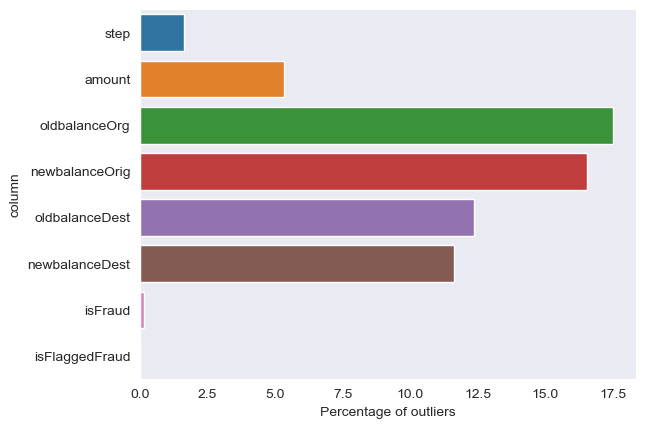

In [17]:
temp = pd.DataFrame(columns_with_outliers, columns = ['column', 'percentage'])

sns.set_style('dark')
sns.barplot(data = temp, y = 'column', x = 'percentage')
plt.xlabel("Percentage of outliers")
sns.despine()
plt.show()

## Multicollinearity

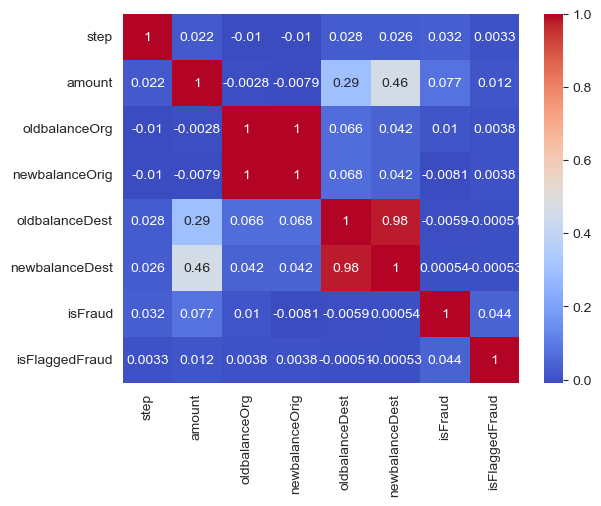

In [18]:
# multicollinearity check 

corr_matrix = numeric_columns.corr()


sns.set_style('white')
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

#### Due to high multicollinearity we will drop the old balance data since we ca use new balance data in place of that because multicollinearity can undermine the statistical significance of an independent variable, reducing the capability of model to identify feature significance....

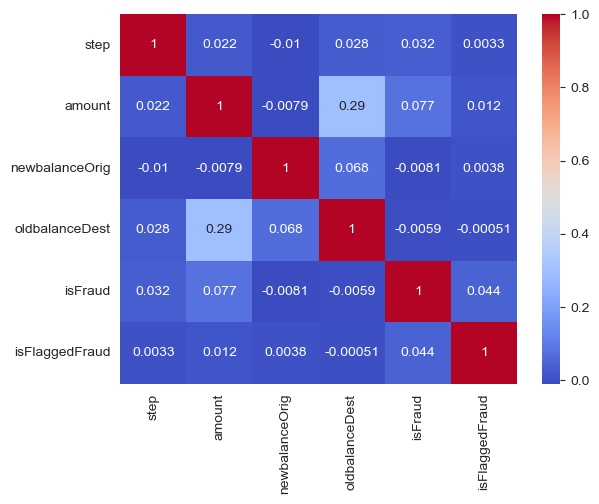

In [19]:
df = data.drop(['oldbalanceOrg', 'newbalanceDest'], axis = 1)

numeric_col = df.select_dtypes(include = ['int64', 'float64'])

correlation_matrix = numeric_col.corr()

sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

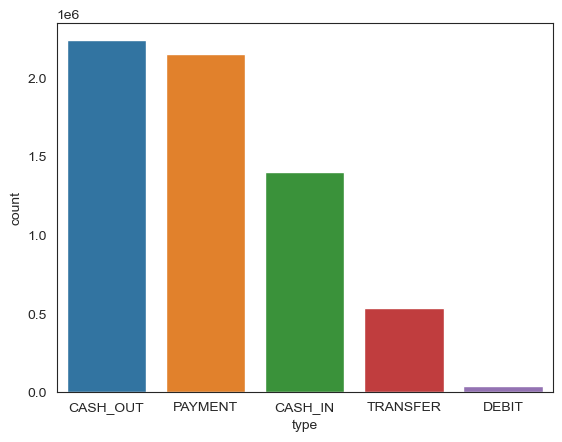

In [20]:
# mode of transactions

sns.countplot(data = df, x = 'type', order = df['type'].value_counts().index)
plt.show()

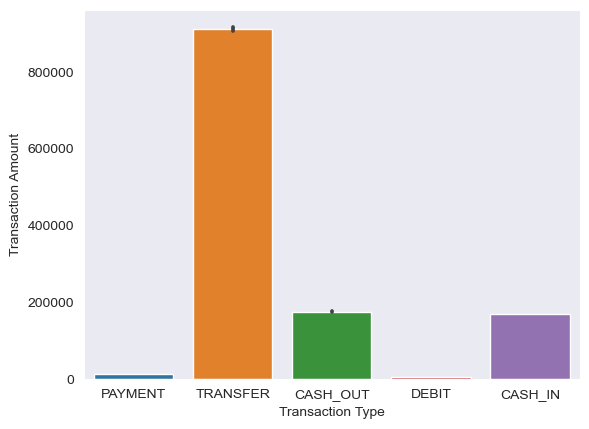

In [21]:
# Amount transferred in each transaction type

sns.set_style('dark')
sns.barplot(data = df, x = 'type', y = 'amount')
plt.xlabel("Transaction Type")
plt.ylabel("Transaction Amount")
plt.show()

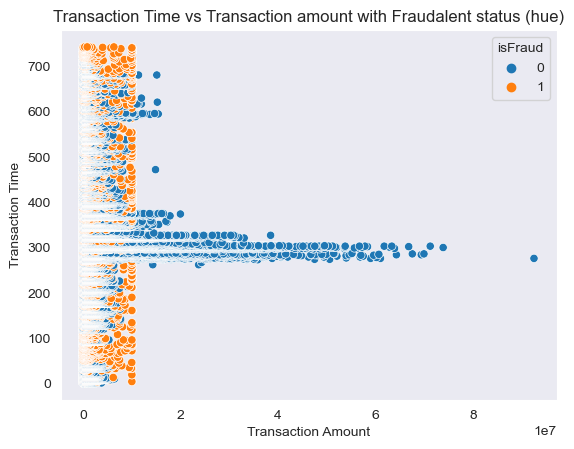

In [22]:
sns.set_style("dark")
sns.scatterplot(data = df, x = 'amount', y = 'step', hue = 'isFraud')
plt.xlabel("Transaction Amount")
plt.ylabel("Transaction Time")
plt.title("Transaction Time vs Transaction amount with Fraudalent status (hue)")
plt.legend(title = 'isFraud')
plt.show()

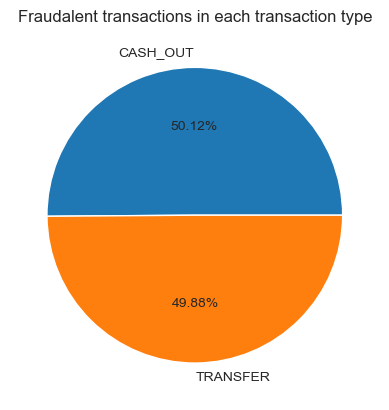

In [23]:
# Fraudalent transactions in each transaction type

temp = df[df['isFraud'] == 1]['type'].value_counts()

plt.pie(x = temp, labels = temp.index, autopct = '%1.2f%%')
plt.title("Fraudalent transactions in each transaction type")
plt.show()

In [24]:
df['isFlaggedFraud'].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

#### Highly unbalanced independent variable 'isFlaggedFraud' so I will drop it

In [25]:
df = data.drop(["isFlaggedFraud", "oldbalanceOrg", "oldbalanceDest"], axis = 1)
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'newbalanceOrig', 'nameDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')

In [26]:
df.head()

,step,type,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,160296.36,M1979787155,0.0,0
1,1,PAYMENT,1864.28,C1666544295,19384.72,M2044282225,0.0,0
2,1,TRANSFER,181.00,C1305486145,0.00,C553264065,0.0,1
3,1,CASH_OUT,181.00,C840083671,0.00,C38997010,0.0,1
4,1,PAYMENT,11668.14,C2048537720,29885.86,M1230701703,0.0,0


## Outliers removal

In [27]:
# removing outliers
def remove_outliers(column):
    # calculating the quantiles for each column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # calculating lower limit and upper limit
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    
    return lower_limit, upper_limit

In [28]:
low_limit, high_limit = remove_outliers('newbalanceOrig')

df['newbalanceOrig'] = np.where(df['newbalanceOrig'] > high_limit, high_limit, df['newbalanceOrig'])
df['newbalanceOrig'] = np.where(df['newbalanceOrig'] < low_limit, low_limit, df['newbalanceOrig'])

In [29]:
low_limit, high_limit = remove_outliers('newbalanceDest')

df['newbalanceDest'] = np.where(df['newbalanceDest'] > high_limit, high_limit, df['newbalanceDest'])
df['newbalanceDest'] = np.where(df['newbalanceDest'] < low_limit, low_limit, df['newbalanceDest'])

# Preprocessing

In [30]:
df = pd.get_dummies(df, columns = ['type'], prefix = ['type'])
df.head()

,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,160296.36,M1979787155,0.0,0,False,False,False,True,False
1,1,1864.28,C1666544295,19384.72,M2044282225,0.0,0,False,False,False,True,False
2,1,181.00,C1305486145,0.00,C553264065,0.0,1,False,False,False,False,True
3,1,181.00,C840083671,0.00,C38997010,0.0,1,False,True,False,False,False
4,1,11668.14,C2048537720,29885.86,M1230701703,0.0,0,False,False,False,True,False


In [31]:
# label encoder

lb = LabelEncoder()
df['nameOrig'] = lb.fit_transform(df['nameOrig'])
df['nameDest'] = lb.fit_transform(df['nameDest'])

In [32]:
df.head()

,step,amount,nameOrig,newbalanceOrig,nameDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,160296.36,1662094,0.0,0,False,False,False,True,False
1,1,1864.28,2188998,19384.72,1733924,0.0,0,False,False,False,True,False
2,1,181.00,1002156,0.00,439685,0.0,1,False,False,False,False,True
3,1,181.00,5828262,0.00,391696,0.0,1,False,True,False,False,False
4,1,11668.14,3445981,29885.86,828919,0.0,0,False,False,False,True,False


In [33]:
df['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

#### Highly imbalanced dataset, so I am using oversampling to make them equal

## Splitting into sets of input and output

In [34]:
X = df.drop('isFraud', axis = 1)
y = df['isFraud']

In [35]:
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

## Using SMOTE

In [36]:
sm = SMOTE(sampling_strategy = 'auto', random_state = 3)

In [37]:
x, y = sm.fit_resample(X, y)

In [38]:
y.value_counts()

isFraud
0    6354407
1    6354407
Name: count, dtype: int64

## Train Test Split

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 3, stratify = y)

In [40]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(9531610, 11)
(3177204, 11)
(9531610,)
(3177204,)


## Normalization

In [41]:
sc = StandardScaler()

x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.fit_transform(x_test)

# Model Building

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
clf_tree = DecisionTreeClassifier()

### Training the algorithm

In [44]:
clf_tree.fit(x_train_sc, y_train)

DecisionTreeClassifier()

In [45]:
clf_tree.score(x_test_sc, y_test)

0.6177292990944239

In [46]:
clf_forest = RandomForestClassifier(n_estimators = 3)

In [83]:
clf_forest.fit(x_train_sc, y_train)

RandomForestClassifier(n_estimators=3)

In [84]:
clf_forest.score(x_test_sc, y_test)

0.5135483903457254

In [49]:
clf_gd = GradientBoostingClassifier(n_estimators = 3)

In [50]:
clf_gd.fit(x_train_sc, y_train)

GradientBoostingClassifier(n_estimators=3)

In [51]:
clf_gd.score(x_test_sc, y_test)

0.8596747328783421

In [52]:
clf_lr = LogisticRegression()

In [53]:
clf_lr.fit(x_train_sc, y_train)

LogisticRegression()

In [54]:
clf_lr.score(x_test_sc, y_test)

0.8592813051979036

#### Here's the results:
1. Decision Tree = 0.617
2. Random Forest = 0.51
3. Gradient Boosting = 0.8597
4. Logistic regression = 0.8593

So, I will use hyperparameter tuning on the best algorithms which produced maximum accuracy i.e. Gradient Boosting Classifier and Logistic Regression.

# Cross-Validation

In [55]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

cvs = StratifiedShuffleSplit(n_splits = 4, test_size = 0.25, random_state = 3)

score = cross_val_score(clf_gd, x, y, cv = cvs)
score

array([0.89855357, 0.89862061, 0.89835654, 0.89853343])

In [ ]:
score = cross_val_score(clf_lr, x, y, cv = cvs)
score

# Grid Search CV

### Gradient Boosting Classifier

In [56]:
param_gridd = {
    'n_estimators' : np.arange(3, 4),
    'learning_rate' : (0.1, 0.3, 0.5, 0.8)
}

cvz = StratifiedShuffleSplit(n_splits = 2, test_size = 0.25, random_state = 3)

In [57]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator = clf_gd, cv = cvz, param_grid = param_gridd, return_train_score = False)
gs.fit(x,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2, random_state=3, test_size=0.25,
            train_size=None),
             estimator=GradientBoostingClassifier(n_estimators=3),
             param_grid={'learning_rate': (0.1, 0.3),
                         'n_estimators': array([3])})

In [58]:
gs.best_score_

0.9177600808761415

In [59]:
gs.best_params_

{'learning_rate': 0.3, 'n_estimators': 3}

### Logistic Regression

In [92]:
param_lr = {
    'C' : (0.1, 0.5, 1.0)
}

In [93]:
gs = GridSearchCV(estimator = clf_lr, cv = cvz, param_grid = param_lr, return_train_score = False)
gs.fit(x,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=2, random_state=3, test_size=0.25,
            train_size=None),
             estimator=LogisticRegression(), param_grid={'C': (0.1, 0.5, 1.0)})

In [94]:
gs.best_score_

0.8438748346030032

In [95]:
gs.best_params_

{'C': 0.1}

## Training the model with best parameters

### Gradient Descent

In [98]:
model = GradientBoostingClassifier(n_estimators = 3, learning_rate = 0.3, random_state = 3)

In [99]:
model.fit(x_train_sc, y_train)

GradientBoostingClassifier(learning_rate=0.3, n_estimators=3, random_state=3)

In [100]:
model.score(x_test_sc, y_test)

0.592650959774695

### Logistic Regression

In [117]:
model_lr = LogisticRegression(C = 0.1)

In [118]:
model_lr.fit(x_train_sc, y_train)

LogisticRegression(C=0.1)

In [119]:
model_lr.score(x_test_sc, y_test)

0.859283508392914

## Accuracy Metrics

### Demonstrate the performance of the model by using best set of tools. 

In [104]:
print(classification_report(y_test, model.predict(x_test_sc)))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71   1588602
           1       1.00      0.19      0.31   1588602

    accuracy                           0.59   3177204
   macro avg       0.77      0.59      0.51   3177204
weighted avg       0.77      0.59      0.51   3177204



<Figure size 1200x600 with 0 Axes>

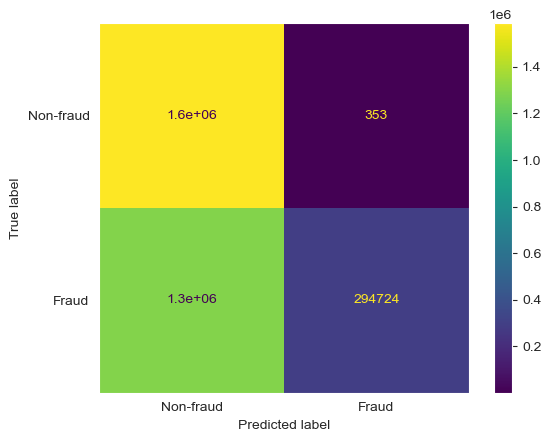

In [105]:
cm = confusion_matrix(y_test, model.predict(x_test_sc))

plt.figure(figsize = (12, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-fraud', 'Fraud'])
cm_display.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

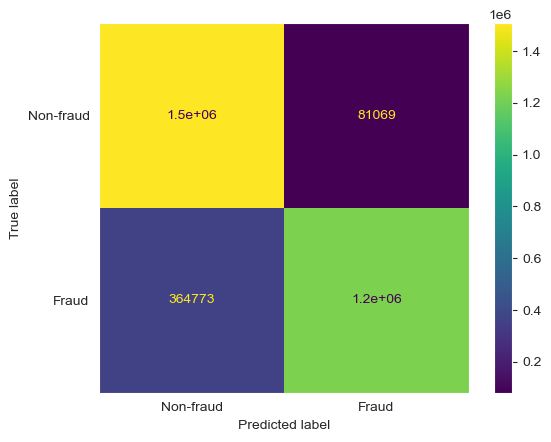

In [113]:
cm = confusion_matrix(y_test, clf_gd.predict(x_test_sc))

plt.figure(figsize = (12, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-fraud', 'Fraud'])
cm_display.plot()
plt.show()

### Logistic Regression

In [106]:
print(classification_report(y_test, model_lr.predict(x_test_sc)))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85   1588602
           1       0.83      0.90      0.86   1588602

    accuracy                           0.86   3177204
   macro avg       0.86      0.86      0.86   3177204
weighted avg       0.86      0.86      0.86   3177204



<Figure size 1200x600 with 0 Axes>

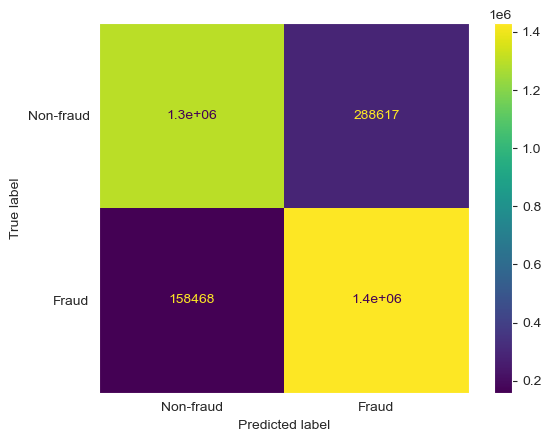

In [107]:
cm = confusion_matrix(y_test, model_lr.predict(x_test_sc))

plt.figure(figsize = (12, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-fraud', 'Fraud'])
cm_display.plot()
plt.show()

In [127]:
# cross-validation for Logistic Regression

score_lr = cross_val_score(model_lr, x, y, cv = cvs)
score_lr

array([0.84372392, 0.84402575, 0.84347338, 0.84395368])

In [128]:
score_lr.mean()

0.8437941819285133

In [125]:
# coefficients indicate the strength and direction of the relationship between each feature and the target variable

feature_coefficients = model_lr.coef_[0]

feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': feature_coefficients
})

feature_importance_df['Absolute_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

In [126]:
feature_importance_df

,Feature,Coefficient,Absolute_Coefficient
10,type_TRANSFER,4.593876,4.593876
7,type_CASH_OUT,4.592605,4.592605
3,newbalanceOrig,-3.208249,3.208249
1,amount,2.652820,2.652820
9,type_PAYMENT,-2.566052,2.566052
5,newbalanceDest,-0.809154,0.809154
0,step,0.808612,0.808612
6,type_CASH_IN,-0.729349,0.729349
8,type_DEBIT,-0.307615,0.307615
4,nameDest,0.064959,0.064959


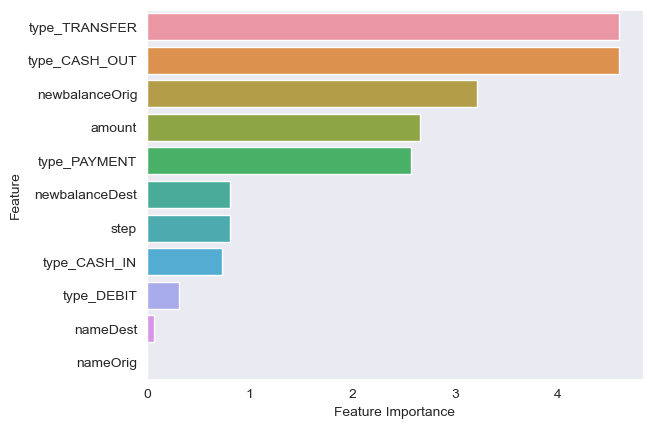

In [131]:
# visual representation of importance of feature input variables

sns.set_style('dark')
sns.barplot(data = feature_importance_df, y = 'Feature', x = 'Absolute_Coefficient')
plt.xlabel("Feature Importance")
plt.show()

#### 1. Describe your fraud detection model in elaboration.

The Fraud detection model is based on the algorithm Logistic Regression classifier. Logistic Regression is a linear model with an activation function i.e. sigmoid function to map the value between 0 and 1. The model is a simple with strong regualrization because of the low value of regularization parameter "C". 

The reason for using Logistic Regression instead of gradient descent is because the model with Logistic Regression has a better tendency to detect the fraud transactions. 
Furthermore, I had used cross-validation in order to check the model accuracy performance of 84.38 %. It have hyper parameters such as regualrization parameter "C" which where further selected on the basis of Grid Search cv algorithm. 

#### 2.  How did you select variables to be included in the model?

I basically selected the features on the basis of Spearman's correlation matrix. The independent variables such as "oldbalanceOrg", "oldBalanceDest" and  "isFlaggedFraud" are the ones that are not included into the input featues. The reason are the following:

a. "oldbalanceOrg" : "oldbalanceOrg" was highly correlated with "newbalanceOrig", so instead of using both it make sense to use                       one out of both, since one can undermine the importance of other. 

b. "oldbalanceDest" : "oldbalanceDest" was highly correlated with "newbalanceDest", so instead of using both it make sense to                         use one out of both, since one can undermine the importance of other.

c. "isFlaggedFraud" : "isFlaggedFraud" was highly imbalanced and the main reason to remove this independent variable is because                       more than 90% of the values are 0 i.e Non-fraud entries in that column.

#### 3. What are the key factors that predict fraudulent customer?

The key factors we identified are that type_TRANFER, type_PAYMENT, type_CASH_OUT , amount, step and newbalanceOrig are playing major role to know is transaction is Fraud or not.

The fraud amount happen in very less time i.e. within or less than 2 steps. 

#### 4. Do these factors make sense? If yes, How? If not, How not?

Yes, these factors make sense because they are somehow showing some patterns that are differenciate the non-fraudalent transactions from fraudalent transactions. Furthermore, they required preprocessing such as encoding, normalization, multicollinearity, outliers etc.

#### 4. What kind of prevention should be adopted while company update its infrastructure?

In future, the company might remove the feature "isFlaggedFraud" beacause it is giving an insight that any transaction above the amount of 200.000 is fraudalent while the transactions lower than 200.000 is non-fraudalent transaction. But that might not be the case since some frauds occur with multiple transactions in small amounts from an savings/current account.

Also, company should have a way to take feedback of transactions that are marked fraudalent from the customers to confirm before taking recovery measures.

#### 5. Assuming these actions have been implemented, how would you determine if they work?

The implementation of the model will save time, prevent frauds helping in increasing customer trust and satisfaction with the organization and finally providing more opportunities with other products within the organization.

#### 6. Data cleaning including missing values, outliers and multi-collinearity

- The data doesn't have any missing or null values, none of the row was duplicated and the data types in each column are correct.

- "newbalanceOrig" and "newbalanceDest" contain the maximum outliers, so removed outliers using statistics i.e. IQR(Inter-Quartile Range)

- 'oldbalanceOrg' and 'newbalanceOrig', 'oldbalanceDest', and 'newbalanceDest' had a perfect linear relation with each other , so I removed the 'oldbalanceOrg' from the first group and 'oldbalanceDest' from the second group.

In [129]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')